<small>
---
© 2025 Monobina Bhowmick-Saha  
Original Repo: https://github.com/monobinab-source/ai-ml/tree/main/emeritus-ai-ml/music_transcribe  
Licensed under the MIT License. See the LICENSE file for details.  
---
</small>


In [ ]:
# This is to set up to connect colab and GCS
# !sudo apt-get update
# !sudo apt-get install gcsfuse

In [ ]:
# authentication threw error
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# one time install librosa in Codio env
!pip install librosa
!pip install pretty_midi
!pip install tensorflow

# !pip install magenta
# !pip install --upgrade --no-cache-dir numpy
# !pip install --upgrade --no-cache-dir pip setuptools wheel
# !pip install --upgrade --no-cache-dir numpy scipy pandas




In [ ]:
pip list | grep numpy

numpy                                 1.26.4


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pretty_midi
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from tensorflow.keras import layers, models
#from magenta import magenta_convert

## Unzip Audio Files for Train & Test

In [ ]:
# training_audio_zip_file = "sample_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.mp3.zip"

# with zipfile.ZipFile(training_audio_zip_file, "r") as zip_ref:
#     zip_ref.extractall("sample_data/processed_data")

# testing_audio_zip_file = "sample_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.mp3.zip"

# with zipfile.ZipFile(testing_audio_zip_file, "r") as zip_ref:
#     zip_ref.extractall("sample_data/processed_data")

In [ ]:

# # Define old and new file names
# old_training_file_name = "sample_data/processed_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.mp3"
# new_training_file_name = "sample_data/processed_data/MIDI-Unprocessed_unzipped-train.mp3"

# # Rename the file
# os.rename(old_training_file_name, new_training_file_name)

# print(f"File renamed from {old_training_file_name} to {new_training_file_name}")

# old_testing_file_name = "sample_data/processed_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.mp3"
# new_testing_file_name = "sample_data/processed_data/MIDI-Unprocessed_unzipped-test.mp3"

# # Rename the file
# os.rename(old_testing_file_name, new_testing_file_name)

# print(f"File renamed from {old_testing_file_name} to {new_testing_file_name}")



### maestrov2 dataset from Kaggle
The entire maestrov2 dataset is downloaded from Kaggle and saved in my local inside Documents folder and then uploaded to GCS.

GCS set up details:
#### 1. From GCP console, a bucket is created named "audio_and_midi_files"
#### 2. A folder is created named "2018"
#### 3. To avoid errors the permissions is set to public for the time being.
#### 4. All other options are kept as default


The mp3 files and corresponding midi files exist in the same folder called sample_data and the file names are consistent:

1. Loop through .mp3 files
2. Find the corresponding .mid file in the same folder

Since there are many files we can pick and choose about 50 files to prevent out of memory issue.

In [ ]:
# ensuring gcs path is visible from here
!gsutil ls gs://audio_and_midi_files/2018/


gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--3.midi
gs:/

### Download Files from GCS and load in local notebook environment

In [ ]:
from google.cloud import storage
import os

project_id = 'monobina-saha'
bucket_name = 'audio_and_midi_files'
data_prefix = '2018/'

# using python storage client connecting to GCS
client = storage.Client(project=project_id)
bucket = client.bucket(bucket_name)

# downloaded files from GCS bucket and folder to the local VM where this colab
#notebook is running for ML use cases faster access of files
local_data_dir = '/tmp/audio_and_midi'
os.makedirs(local_data_dir, exist_ok=True)

blobs = list(bucket.list_blobs(prefix=data_prefix))

print(f"Found {len(blobs)} files")

# not getting all files from GCS. Getting only 100 files for efficiency and cost
file_count = 0
max_files = 100

for blob in blobs:
    if blob.name.endswith('.mp3') or blob.name.endswith('.midi') or blob.name.endswith('.mid'):
        filename = os.path.basename(blob.name)

        if filename == "":
            continue

        local_path = os.path.join(local_data_dir, filename)
        print(f"Downloading {filename}...")
        blob.download_to_filename(local_path)

        file_count += 1
        if file_count >= max_files:
            break

# checked in left panel of colab inside vertex ai => files => tmp=> audio_and_midi => 2018 => files
print("Download complete.")
print("Files downloaded:", os.listdir(local_data_dir))



Found 199 files
Download complete.
Files downloaded: ['MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--3.midi', 'MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--1.midi', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--1.mp3', 'MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--3.mp3', 'MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--2.mp3', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--4.mp3', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--2.midi', 'MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--3.mp3', 'MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--1.mp3', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R

## Audio Data Exploration & Feature Extraction


### Digitize Audio Signal & Load in Variables
Digital audio is a discrete representation of continuous sound waves.
Sampling rate refers to the number of times per second that a sound wave is measured (or sampled) to create the digital representation. It's measured in Hertz (Hz).
A higher sampling rate generally captures more detail of the audio, leading to better quality.
Why 22050 Hz?

Common Standard: 22050 Hz is a widely used standard sampling rate in audio processing. It's considered sufficient for capturing the frequencies audible to most humans.

Nyquist-Shannon Sampling Theorem states that to accurately reconstruct a signal, the sampling rate must be at least twice the highest frequency present in the signal. Since the human hearing range is roughly up to 20,000 Hz, 22050 Hz provides enough samples to capture those frequencies.

Computational Efficiency: Using a lower sampling rate (like 22050 Hz compared to 44100 Hz) can reduce the amount of data and processing power needed, making tasks like feature extraction and model training more efficient.

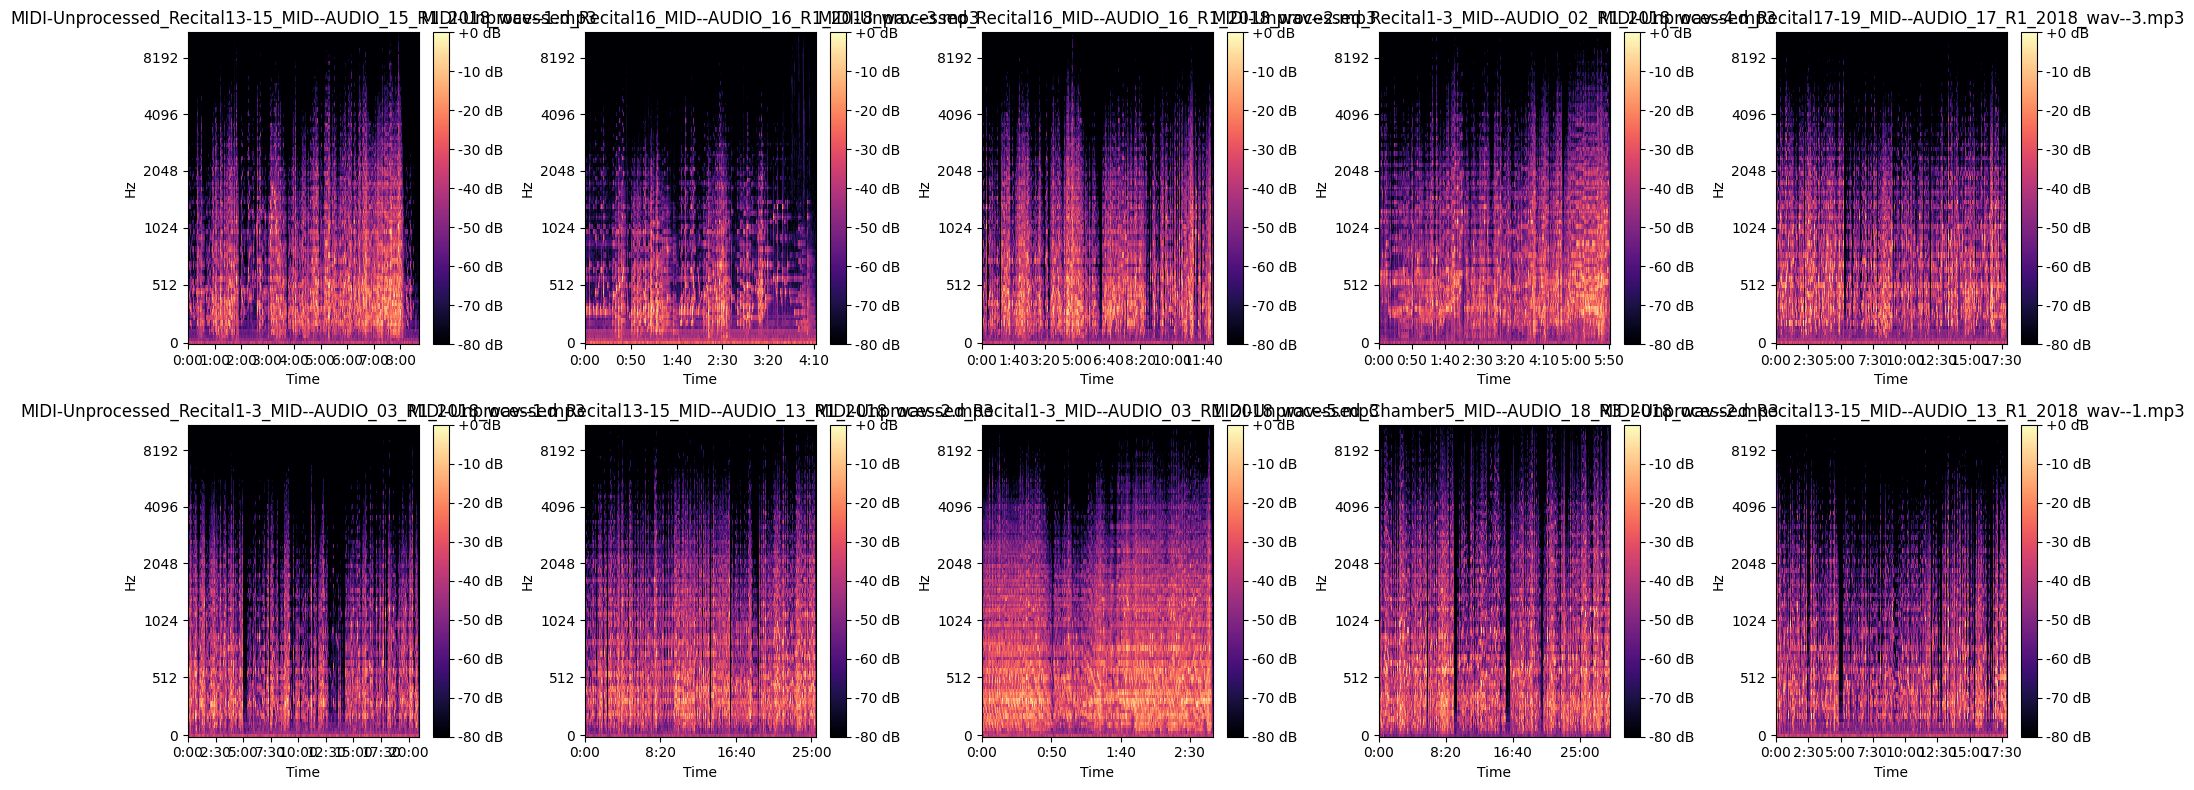

In [ ]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Get a list of all MP3 files in the local folder '/tmp/audio_and_midi'
mp3_files = glob.glob("/tmp/audio_and_midi/*.mp3")

# For exploration, we choose the first 10 files (adjust as needed)
num_samples = 10
sample_files = mp3_files[:num_samples]

# Prepare list to store spectrogram shapes for later review
spectrogram_shapes = []

# Set up subplots in a grid; adjust rows/cols based on number of samples
ncols = 5
nrows = (num_samples + ncols - 1) // ncols  # ceiling division for number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
axes = axes.flatten()  # ease indexing

# Loop through each selected MP3 file
for i, file_path in enumerate(sample_files):
    # Load audio file from /tmp/audio_and_midi
    y, sr = librosa.load(file_path, sr=22050)

    # Compute Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # Convert to log scale (dB)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Save the shape for reference
    spectrogram_shapes.append(log_spectrogram.shape)

    # Plot in the subplot; you can change x_axis and y_axis options as desired
    img = librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel', ax=axes[i])
    axes[i].set_title(os.path.basename(file_path))
    fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

# Hide any empty subplots (if fewer than nrows*ncols files)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Print out the shapes of the log-spectrograms for each file
print("Shapes of the log-mel spectrograms:")
for shape in spectrogram_shapes:
    print(shape)




### Get mel spectogram from one song and plot it

Shapes of the log-mel spectrograms:
(128, 22447)
(128, 10839)
(128, 31389)
(128, 15103)
(128, 46071)
(128, 54052)
(128, 65815)
(128, 7172)
(128, 74232)
(128, 46182)


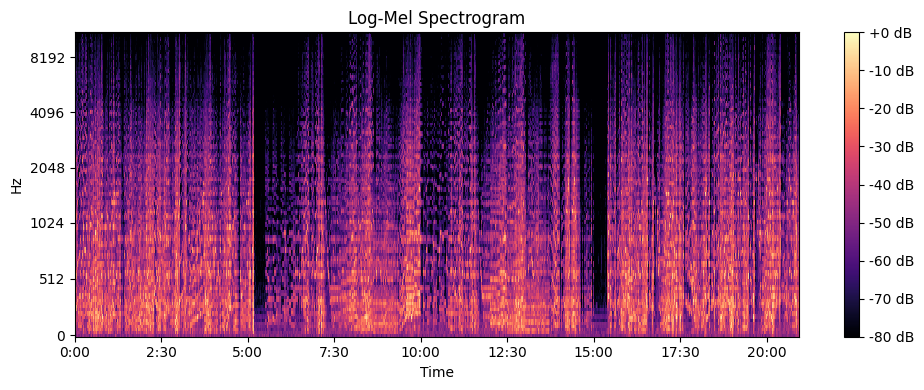

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Specify the path to a single audio file in your local directory
audio_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"

# Load the audio; librosa.load will resample it to 22050 Hz by default
y, sr = librosa.load(audio_path, sr=22050)

# Compute the Mel spectrogram with 128 Mel bands
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert the power spectrogram to a logarithmic scale (in decibels) to make it standardised
log_mel = librosa.power_to_db(mel_spec, ref=np.max)

# Plot the log-mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


### Numerical representation of audio data
Here's how we can get a glimpse of the numerical embeddings (log-mel spectrogram) that are created as features in the pipeline. In our case, these “embeddings” are essentially the log-scaled Mel spectrogram values—a 2D NumPy array where each row represents a Mel frequency band and each column represents a time frame.

In [ ]:
import librosa
import librosa.display
import numpy as np

# Path to one audio file in your local environment (adjust the path as needed)
audio_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"

# Load the audio (resampling to 22050 Hz)
y, sr = librosa.load(audio_path, sr=22050)

# Compute the Mel spectrogram with 128 Mel bins/bands. “128” means there are 128 different frequency channels being captured.
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert to log scale (in decibels)
log_mel = librosa.power_to_db(mel_spec, ref=np.max)

# Print the shape of the embedding (e.g., (128, time_frames)). For example, if I have an audio file of length
#T seconds sampled at 22050 Hz, I have about 22050*T samples. If you use a hop length of 512, then the approximate number of frames is:(22050*T)/512
print("Shape of the log-mel spectrogram (embedding):", log_mel.shape)

# Print a small sample (first 5 rows and first 10 columns)
print("Sample numerical embedding values (first 5 Mel bands, first 10 time frames):")
print(log_mel[:5, :10])


Shape of the log-mel spectrogram (embedding): (128, 54096)
Sample numerical embedding values (first 5 Mel bands, first 10 time frames):
[[-56.709393 -53.176792 -59.328182 -51.143177 -47.138245 -51.23387
  -52.139297 -46.46357  -48.665955 -48.09493 ]
 [-53.650818 -50.696117 -52.008636 -51.541836 -47.065186 -51.460014
  -51.099594 -45.08458  -47.05046  -52.433167]
 [-54.415005 -53.63242  -53.1332   -55.494698 -56.127747 -53.730858
  -53.5968   -56.81347  -55.758472 -59.749763]
 [-55.228127 -53.720047 -51.840637 -50.51509  -51.10706  -50.87343
  -51.32392  -55.153625 -52.20302  -51.586777]
 [-58.494766 -53.854427 -50.157997 -49.20588  -49.173912 -48.715027
  -50.744934 -52.256752 -50.36964  -50.405495]]


### Building X and Y
X => log mel spectogram

Y => piano roll

In [ ]:
import os
import librosa
import pretty_midi
import numpy as np

# Directory with downloaded MP3 and MIDI files
data_dir = "/tmp/audio_and_midi"
sr = 16000  # Audio sample rate

X = []
Y = []
pair_count = 0
max_pairs = 50  # Limit to avoid OOM errors

# Loop through downloaded files
for filename in os.listdir(data_dir):
    if filename.endswith(".mp3"):
        base_name = os.path.splitext(filename)[0]
        audio_path = os.path.join(data_dir, base_name + ".mp3")
        midi_path = os.path.join(data_dir, base_name + ".midi")

        if os.path.exists(midi_path):
            try:
                # Load audio
                y, _ = librosa.load(audio_path, sr=sr)
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)

                # Load MIDI
                midi_data = pretty_midi.PrettyMIDI(midi_path)
                piano_roll = midi_data.get_piano_roll(fs=100)[21:109, :]  # 88 keys only

                # Ensure enough frames
                if log_mel.shape[1] >= 100 and piano_roll.shape[1] >= 100:
                    X.append(log_mel[:, :100])
                    Y.append(piano_roll[:, :100])
                    pair_count += 1

            except Exception as e:
                print(f"Error processing {base_name}: {e}")

        if pair_count >= max_pairs:
            break

print("Processed pairs:", pair_count)



Processed pairs: 50


### Extract Basic Features from Spectogram of Audio
We can extract Mel Spectrogram and MFCCs (Mel-Frequency Cepstral Coefficients), which are widely used for audio classification.
Why use these features?

Mel Spectrogram represents how sound energy is
distributed across frequencies over time.

1. MFCCs: This is useful for distinguishing different sounds (used in speech recognition and music classification). They capture the spectral envelope of the sound and are robust to variations in loudness and recording conditions.

2. Spectral Centroid: This feature represents the "center of mass" of the spectrum, indicating the average frequency weighted by amplitude.

3. Spectral Bandwidth: This measures the width of the spectrum, indicating the range of frequencies present in the sound.

4. Zero-Crossing Rate: This feature counts the number of times the audio waveform crosses zero, providing information about the frequency content and noisiness of the sound.

5. Chroma Features: These represent the distribution of energy across the 12 chromatic pitches (C, C#, D, etc.), providing information about the harmonic content of the music.

6. Note Onsets and Offsets: You can extract the time points where notes start (onsets) and end (offsets) to analyze rhythmic patterns.

### Extract Features from Piano Roll (Y)

1. Note Density: This feature calculates the number of notes played per time frame, indicating the musical texture.

2. Pitch Class Distribution: This represents the distribution of notes across the 12 pitch classes (C, C#, D, etc.), providing information about the key or scale of the music.




In [ ]:
# Feature extraction after splitting
audio_features = []
piano_roll_features = []

print("Length of X: ", len(X))

for i in range(len(X)):
    # Features from digitized audio (X)
    mfccs = librosa.feature.mfcc(y=X[i], sr=sr, n_mfcc=13)  # Assuming you have the sampling rate (sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=X[i], sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=X[i], sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=X[i])
    chroma_features = librosa.feature.chroma_stft(y=X[i], sr=sr)
    onsets = librosa.onset.onset_detect(y=X[i], sr=sr) # Assuming you have audio corresponding to the piano roll


    audio_features.append(np.concatenate([mfccs.flatten(), spectral_centroid.flatten(), spectral_bandwidth.flatten(), zero_crossing_rate.flatten(), chroma_features.flatten()]))  # Combine features

    # Features from piano roll (Y)
    note_density = np.sum(Y[i], axis=0)
    pitch_class_distribution = np.sum(Y[i], axis=1) % 12

    # ... extract other piano roll features ...

    piano_roll_features.append(np.concatenate([note_density, pitch_class_distribution])) # Combine features


# Convert to NumPy arrays
audio_features = np.array(audio_features)
piano_roll_features = np.array(piano_roll_features)





Length of X:  50


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=100
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


### Data Exploration and printing for visual understanding


In [ ]:
# check length and type of audio fetaures and piano roll features
print(len(audio_features))
print(len(piano_roll_features))
print(type(audio_features))
print(type(piano_roll_features))

# Print shapes of individual features
print("MFCCs shape:", mfccs.shape)
print("Spectral Centroid shape:", spectral_centroid.shape)
print("Spectral Bandwidth shape:", spectral_bandwidth.shape)
print("Zero-Crossing Rate shape:", zero_crossing_rate.shape)
print("Chroma Features shape:", chroma_features.shape)
print("Audio Features Shape:", audio_features.shape)
print("Piano Roll Features Shape:", piano_roll_features.shape)

# print("MFCCs:", mfccs)
# Print first sample
print("First X sample:\n", audio_features[0])
print("First Y sample:\n", piano_roll_features[0])


50
50
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
MFCCs shape: (128, 13, 1)
Spectral Centroid shape: (128, 1, 1)
Spectral Bandwidth shape: (128, 1, 1)
Zero-Crossing Rate shape: (128, 1, 1)
Chroma Features shape: (128, 12, 1)
Audio Features Shape: (50, 3584)
Piano Roll Features Shape: (50, 188)
First X sample:
 [344.41830444  88.54086304  18.40383148 ...   1.           0.90164512
   0.87763405]
First Y sample:
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. 42. 42. 42. 79. 79. 79.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

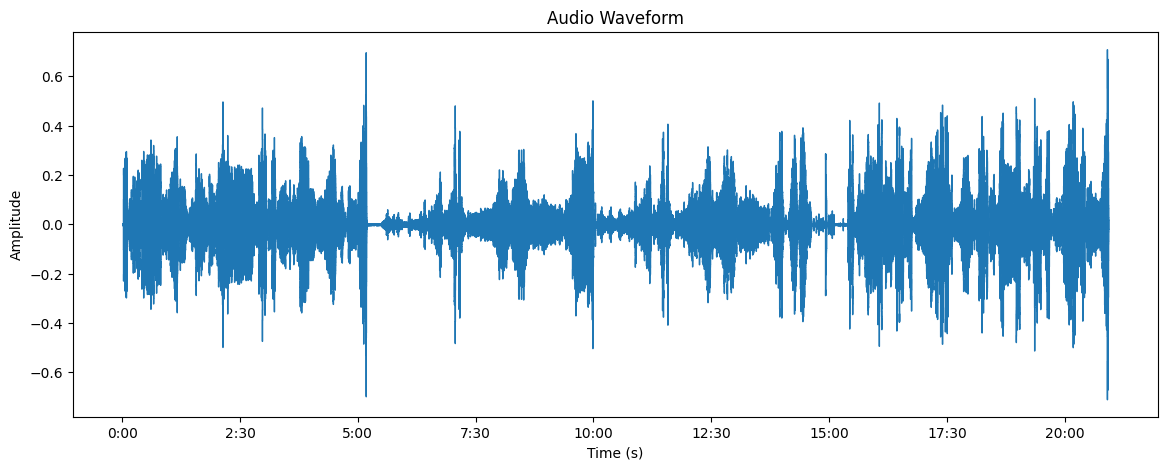

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

sample_test_audio_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
y, sr = librosa.load(sample_test_audio_path, sr=22050)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


#### Mel Spectogram and MFCC Visualization

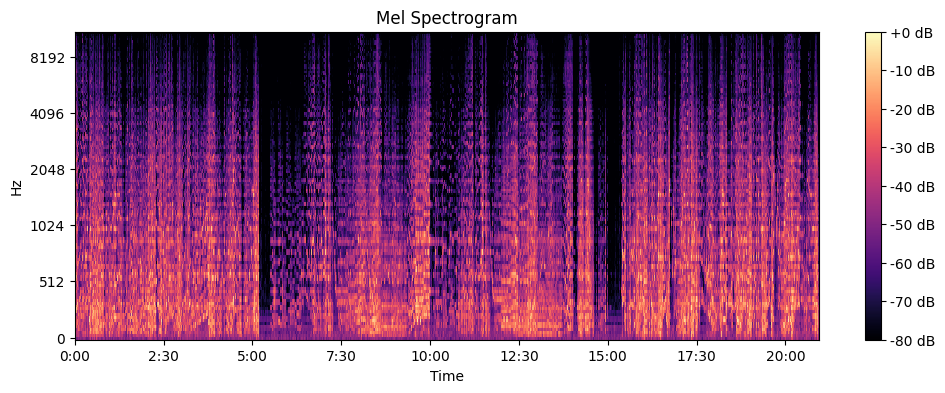

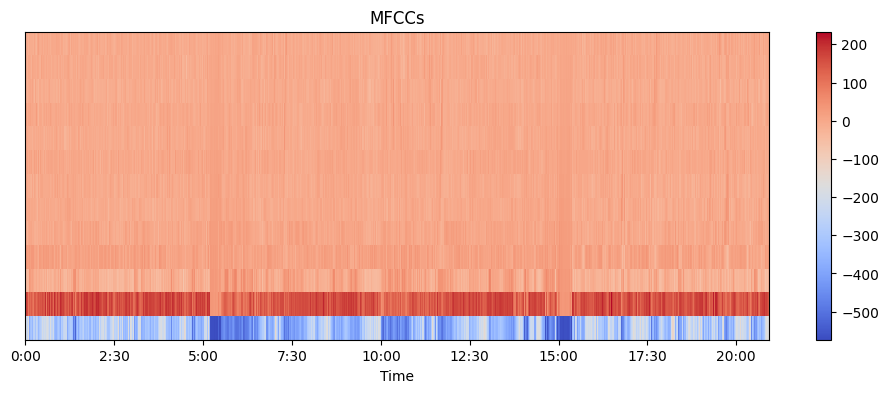

In [ ]:

# Compute Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot Mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.show()


### The Mel spectrogram plot
It provides a visual representation of the frequency content of your MP3 file over time. Here's what it tells us:

1. X-axis (Time)
Represents time in seconds.
Shows how the audio's frequency components change over time.
2. Y-axis (Frequency - Mel Scale)
Represents frequency, but instead of linear Hz, it's in the Mel scale, which aligns with human perception.
Lower values = lower-pitched sounds (bass, deep voice).
Higher values = higher-pitched sounds (treble, sharp sounds).
3. Color Intensity (dB - Decibels)
Shows the amplitude (loudness) of each frequency component.
Brighter (yellow/white) = louder sounds at that frequency.
Darker (blue/purple) = softer sounds.

### Align Audio and MIDI
To train the CNN, you need aligned audio and MIDI representations:
Spectrogram (input) and piano roll (output) must correspond in time.
Use libraries like pretty_midi or custom alignment logic to ensure this.


In [ ]:
# import glob

# # Get list of MIDI files
# midi_files = glob.glob("sample_data/*.midi")

# # Pick one MIDI file
# midi_path = midi_files[0]

# # Load and convert to piano roll
# midi_data = pretty_midi.PrettyMIDI(midi_path)
# piano_roll = midi_data.get_piano_roll(fs=100)  # shape: (128 pitches, time frames)

# print(f"Piano roll shape: {piano_roll.shape}")


In [ ]:
# # Display piano roll
# plt.figure(figsize=(10, 4))
# plt.imshow(piano_roll, aspect='auto', cmap='hot', origin='lower')
# plt.title('Piano Roll')
# plt.ylabel('MIDI Note')
# plt.xlabel('Time')
# plt.colorbar()
# plt.show()

### The Piano Roll Plot
The piano roll plot provides a visual representation of how MIDI notes are played over time. Here's what it tells us:

1. X-axis (Time)
Represents time in seconds or frames (depending on fs=100).
Shows when notes start and how long they last.
2. Y-axis (MIDI Note Numbers)
Represents pitches of the notes played.
Higher values = higher-pitched notes (treble).
Lower values = lower-pitched notes (bass).
Middle C (C4) = MIDI note 60.
3. Color Intensity (Velocity)
Indicates how strongly or softly the notes are played.
Brighter (yellow/white) = louder notes.
Darker (red/black) = softer notes.


### Load audio data for digitization
For modeling audio and midi files are loaded into Python's Librosa library to be able to perform supervised learning using audio and the label.

In [ ]:
X = np.array(X)
Y = np.array(Y)

np.save('/tmp/X.npy', X)
np.save('/tmp/Y.npy', Y)

print("Saved features to /tmp")


Saved features to /tmp


### Upload X and Y in GCS
This is to make data available for reuse.

In [ ]:
from google.cloud import storage

bucket = storage.Client().bucket('processed_audio_for_model_use')

bucket.blob('2018/X.npy').upload_from_filename('/tmp/X.npy')
bucket.blob('2018/Y.npy').upload_from_filename('/tmp/Y.npy')

print("Uploaded to GCS!")

Uploaded to GCS!


### Download training data from GCS

In [ ]:
from google.cloud import storage
import os

bucket_name = "processed_audio_for_model_use"
prefix = "2018/"
local_dir = "/tmp/"

# Initialize the client
client = storage.Client()
bucket = client.bucket(bucket_name)

# List all blobs under the prefix (folder)
blobs = bucket.list_blobs(prefix=prefix)

for blob in blobs:
    # Skip directories or non-relevant files
    if blob.name.endswith("/"):
        continue
    if not (blob.name.endswith(".npy") or blob.name.endswith(".pkl")):
        continue

    # Local file path
    local_path = os.path.join(local_dir, os.path.basename(blob.name))
    blob.download_to_filename(local_path)
    print(f"Downloaded {blob.name} to {local_path}")



Downloaded 2018/X.npy to /tmp/X.npy
Downloaded 2018/X_sliced.npy to /tmp/X_sliced.npy
Downloaded 2018/X_supervised.npy to /tmp/X_supervised.npy
Downloaded 2018/X_test.npy to /tmp/X_test.npy
Downloaded 2018/X_train.npy to /tmp/X_train.npy
Downloaded 2018/Y.npy to /tmp/Y.npy
Downloaded 2018/Y_sliced.npy to /tmp/Y_sliced.npy
Downloaded 2018/Y_supervised.npy to /tmp/Y_supervised.npy
Downloaded 2018/Y_test.npy to /tmp/Y_test.npy
Downloaded 2018/Y_train.npy to /tmp/Y_train.npy


### Data Preparation for Model Training
1. Adding channel: CNN models expect input like (height, width, channels). For audio spectrograms, channel = 1 (like grayscale images).

2. Normalization: Scales values between 0 and 1. Helps model converge faster. Prevents large value domination.

In [ ]:
import numpy as np

X = np.array(X)
Y = np.array(Y)

# Add channel dimension to X: shape becomes (50, 128, 100, 1)
X = X[..., np.newaxis]

# Normalize X
X = X / np.max(X)

### Split the dataset into train and test for model training and evaluation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


### Will try Convolutional Neural Network model
This model was originally created for image classification but since audio spectogram looks like image I can use it for audio.
Audio → Spectrogram (because it's an image of sound)

#### Output of Conv2D Layer
Looks like → filtered images.

It learns:

Edges

Patterns

Transitions

Texture

Pitch or Frequency change (when used in audio spectrograms)

Other signature components of CNN:
Layer	              Role
============================
MaxPooling2D	      Downsample → Reduces size but keeps important info

Flatten	            Convert 2D/3D to 1D vector

Dense	              Final decision making layers

Reshape	            To desired output shape

Input: (128, 100, 1)
→ This is a 2D log-mel spectrogram with time steps = 100
→ Perfect for CNN input

Conv2D with small filters (3*3)
→ Detects local time-frequency patterns (e.g. harmonics, note onsets)

MaxPooling2D
→ Reduces resolution and adds translation invariance
→ Common in audio models

Dense(512) → Dense(88*100)
→ Flattens into a vector, then maps to your full piano roll (88 notes * 100 time frames)

sigmoid + binary_crossentropy
→ Piano roll is multi-label (multiple notes at each timestep), so binary classification is correct

Reshape((88, 100))
→ Final output matches your ground truth format



In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(128, 100, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'), # That's the signature of a CNN. 2D Convolution Layer, Filter size 3x3 — looks at local patterns, Number of filters (feature maps it learns)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(88 * 100, activation='sigmoid'),
    layers.Reshape((88, 100))  # Match target shape
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8800)                │       4,514,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 88, 100)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,748,128 (117.29 MB)

 Trainable params: 30,748,128 (117.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_test, Y_test)
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.0014 - loss: 1.0913 - val_accuracy: 0.0034 - val_loss: 0.5748
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.0110 - loss: 0.4529 - val_accuracy: 0.0023 - val_loss: 0.1436
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.0052 - loss: 0.0187 - val_accuracy: 0.0034 - val_loss: 0.1833
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.0059 - loss: -0.2654 - val_accuracy: 0.0057 - val_loss: 0.1797
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.0062 - loss: -0.5445 - val_accuracy: 0.0034 - val_loss: 0.2637
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.0159 - loss: -0.6386 - val_accuracy: 0.2000 - val_loss: 0.2859
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.4251 - loss: -0.4314 - val_accuracy: 0.5818 - val_loss: 0.2926
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.5928 - loss: -0.9187 - val_accuracy: 0.5920 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5909 - loss: 0.3034
Test Accuracy: 0.5909
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


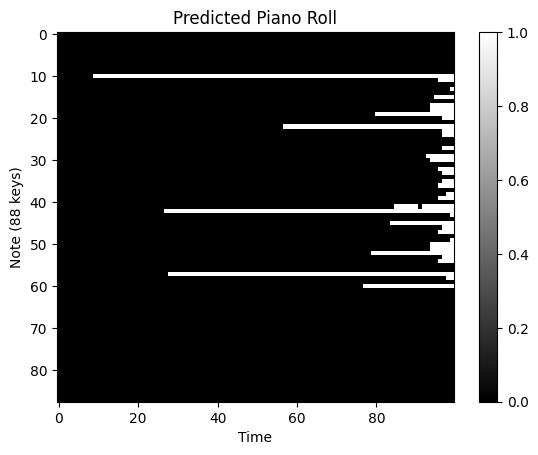

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict a test sample
import matplotlib.pyplot as plt

i = 0
pred = model.predict(X_test[i:i+1])[0]  # shape: (88, 100)
pred_binary = (pred > 0.5).astype(int)

plt.imshow(pred_binary, aspect='auto', cmap='gray')
plt.title("Predicted Piano Roll")
plt.xlabel("Time")
plt.ylabel("Note (88 keys)")
plt.colorbar()
plt.show()


In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Model input shape: log-mel spectrogram slice (128 Mel bands, 100 frames)
input_shape = (128, 100, 1)

cnn_model_2 = models.Sequential([
    layers.Input(shape=input_shape),

    # More context: stack 2 Conv layers before pooling
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.3),  # Overfitting control

    # Flatten spatial structure
    layers.Flatten(),

    # Fully connected
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),  # Overfitting control

    # Output: predict 88 notes × 100 frames → 8800 binary outputs
    layers.Dense(88 * 100, activation='sigmoid'),

    layers.Reshape((88, 100))  # Reshape to piano roll format
])


cnn_model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8800)                │       4,514,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 88, 100)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,794,304 (117.47 MB)

 Trainable params: 30,794,304 (117.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_model_2_fitted = cnn_model_2.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_test, Y_test)
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 549ms/step - accuracy: 0.0065 - loss: 1.0986 - val_accuracy: 0.0239 - val_loss: 0.5487
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - accuracy: 0.0075 - loss: 0.4460 - val_accuracy: 0.0023 - val_loss: 0.1249
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step - accuracy: 0.0059 - loss: 0.1383 - val_accuracy: 0.0034 - val_loss: 0.0568
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.0077 - loss: 0.0469 - val_accuracy: 0.0011 - val_loss: 0.0511
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.0087 - loss: -0.1173 - val_accuracy: 0.0125 - val_loss: 0.0486
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.0076 - loss: -0.1989 - val_accuracy: 0.0136 - val_loss: 0.1111
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.0083 - loss: -0.4362 - val_accuracy: 0.0023 - val_loss: 0.2349
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.0417 - loss: -0.9120 - val_accuracy: 0.5148 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5898 - loss: 0.2959
Test Accuracy: 0.5898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


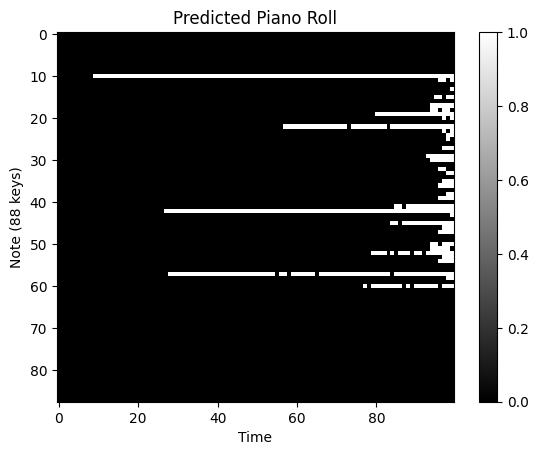

In [ ]:
loss, accuracy = cnn_model_2.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict a test sample
import matplotlib.pyplot as plt

i = 0
pred = cnn_model_2.predict(X_test[i:i+1])[0]  # shape: (88, 100)
pred_binary = (pred > 0.5).astype(int)

plt.imshow(pred_binary, aspect='auto', cmap='gray')
plt.title("Predicted Piano Roll")
plt.xlabel("Time")
plt.ylabel("Note (88 keys)")
plt.colorbar()
plt.show()

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Model input shape: log-mel spectrogram slice (128 Mel bands, 100 frames)
input_shape = (128, 100, 1)

cnn_model_3 = models.Sequential([
    layers.Input(shape=input_shape),

    # More context: stack 2 Conv layers before pooling
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.3),  # Overfitting control

    # Flatten spatial structure
    layers.Flatten(),

    # Fully connected
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),  # Overfitting control

    # Output: predict 88 notes × 100 frames → 8800 binary outputs
    layers.Dense(88 * 100, activation='sigmoid'),

    layers.Reshape((88, 100))  # Reshape to piano roll format
])


cnn_model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8800)                │       4,514,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 88, 100)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,794,304 (117.47 MB)

 Trainable params: 30,794,304 (117.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Example (you’ll need to compute based on your data):
note_on_weight = 3.0  # more penalty for missing an active note
note_off_weight = 1.0

# Custom loss function
def weighted_binary_crossentropy(y_true, y_pred):
    weights = y_true * note_on_weight + (1 - y_true) * note_off_weight
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce * weights)

cnn_model_3.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])


In [ ]:
cnn_model_3_fitted = cnn_model_3.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_test, Y_test)
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - accuracy: 0.0126 - loss: 86.0662 - val_accuracy: 0.0000e+00 - val_loss: 4.0940
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.0101 - loss: 3.2284 - val_accuracy: 0.0011 - val_loss: 0.1009
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.0073 - loss: -0.5710 - val_accuracy: 0.0023 - val_loss: -2.7427
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.0067 - loss: -11.6485 - val_accuracy: 0.0159 - val_loss: -27.5189
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.0102 - loss: -102.6863 - val_accuracy: 0.4364 - val_loss: -43.6618
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.3317 - loss: -163.3218 - val_accuracy: 0.5898 - val_loss: -45.7842
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - accuracy: 0.5872 - loss: -218.7283 - val_accuracy: 0.5898 - val_loss: -45.7744
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.5936 - loss: -224.5662 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5898 - loss: -46.1632
Test Accuracy: 0.5898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


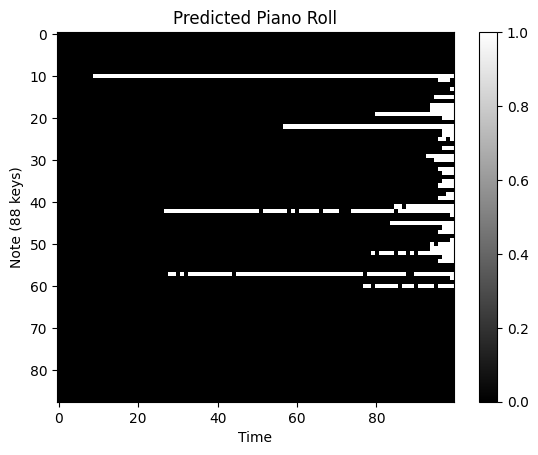

In [ ]:
loss, accuracy = cnn_model_3.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict a test sample
import matplotlib.pyplot as plt

i = 0
pred = cnn_model_3.predict(X_test[i:i+1])[0]  # shape: (88, 100)
pred_binary = (pred > 0.5).astype(int)

plt.imshow(pred_binary, aspect='auto', cmap='gray')
plt.title("Predicted Piano Roll")
plt.xlabel("Time")
plt.ylabel("Note (88 keys)")
plt.colorbar()
plt.show()

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

input_shape = (128, 100, 1)

model_td = models.Sequential([
    layers.Input(shape=input_shape),

    # Convolutional blocks
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.3),

    # Reshape to (time_steps, features)
    layers.Reshape((25, -1)),  # 100 frames → 25 after two 2× pooling ops

    # TimeDistributed dense across time
    layers.TimeDistributed(layers.Dense(256, activation='relu')),
    layers.TimeDistributed(layers.Dense(88, activation='sigmoid')),  # per time-step prediction of 88 notes

    layers.Permute((2, 1))  # Reshape to (88 notes, time)
])


In [ ]:
model_td.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_td.summary()
# Use only every 4th time step → 100 → 25
Y_train_ds = Y_train[:, :, ::4]
Y_test_ds  = Y_test[:,  :, ::4]

model_td.fit(X_train, Y_train_ds, epochs=10, batch_size=8, validation_data=(X_test, Y_test_ds))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 128, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 25, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 25, 256)             │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 25, 88)              │          22,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute (Permute)                    │ (None, 88, 25)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 612,152 (2.34 MB)

 Trainable params: 612,152 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step - accuracy: 0.0418 - loss: 0.9506 - val_accuracy: 0.1739 - val_loss: 0.3980
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.0913 - loss: 0.1530 - val_accuracy: 0.2420 - val_loss: 0.4742
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.1575 - loss: -0.0424 - val_accuracy: 0.3852 - val_loss: 0.6336
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.3039 - loss: -0.1539 - val_accuracy: 0.5057 - val_loss: 0.6921
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.3684 - loss: -0.6257 - val_accuracy: 0.4682 - val_loss: 0.6113
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.3629 - loss: -0.1950 - val_accuracy: 0.3159 - val_loss: 0.7155
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.2854 - loss: 0.0786 - val_accuracy: 0.3648 - val_loss: 0.5891
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.2910 - loss: -0.4025 - val_accuracy: 0.2614 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5045 - loss: 0.5864
Test Accuracy: 0.5045
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


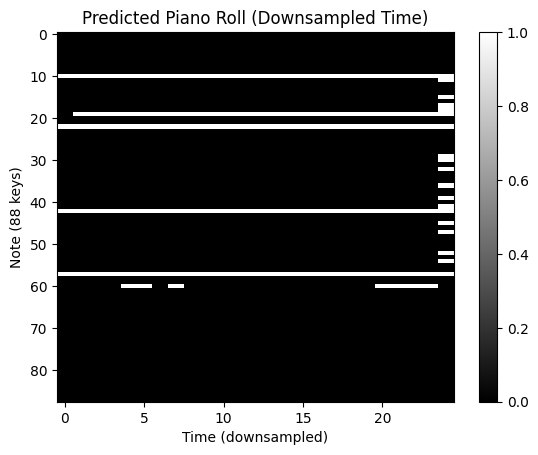

In [ ]:
# Evaluate with downsampled labels
loss, accuracy = model_td.evaluate(X_test, Y_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict a test sample
import matplotlib.pyplot as plt

i = 0
pred = model_td.predict(X_test[i:i+1])[0]  # shape: (88, 25)
pred_binary = (pred > 0.5).astype(int)

plt.imshow(pred_binary, aspect='auto', cmap='gray')
plt.title("Predicted Piano Roll (Downsampled Time)")
plt.xlabel("Time (downsampled)")
plt.ylabel("Note (88 keys)")
plt.colorbar()
plt.show()


In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

input_shape = (128, 100, 1)

model_cnn1d = models.Sequential([
    layers.Input(shape=input_shape),

    # Block 1: 2D Convs for local features
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),  # Output shape: (64, 50, 32)
    # layers.MaxPooling2D((2, 1), padding='same'),  # only reduce frequency dim, not time

    # Reshape for Conv1D across time (frames)
    layers.Permute((2, 1, 3)),  # Swap to (time, mel, channels)
    layers.Reshape((50, 64 * 32)),  # (time, features)

    # Conv1D across time
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.Dropout(0.3),
    layers.Conv1D(88, kernel_size=1, activation='sigmoid'),  # 88 notes per timestep

    # Output shape: (time=50, notes=88)
    layers.Permute((2, 1))  # Reshape to (88, 50)
])

model_cnn1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn1d.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 128, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute_1 (Permute)                  │ (None, 50, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 50, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 50, 128)             │         786,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 50, 88)              │          11,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute_2 (Permute)                  │ (None, 88, 50)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 807,480 (3.08 MB)

 Trainable params: 807,480 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Downsample time from 100 to 50 (if needed)
Y_train_ds = Y_train[:, :, ::2]
Y_test_ds  = Y_test[:, :, ::2]

model_cnn1d.fit(
    X_train, Y_train_ds,
    epochs=10,
    batch_size=8,
    validation_data=(X_test, Y_test_ds)
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.0394 - loss: 2.3181 - val_accuracy: 0.2057 - val_loss: 0.6425
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.0467 - loss: 0.3770 - val_accuracy: 0.1693 - val_loss: 0.5435
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.1094 - loss: 0.5484 - val_accuracy: 0.1239 - val_loss: 0.5077
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.0641 - loss: 0.3904 - val_accuracy: 0.0841 - val_loss: 0.3852
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.0303 - loss: 0.2595 - val_accuracy: 0.0841 - val_loss: 0.3926
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.0332 - loss: 0.2164 - val_accuracy: 0.1170 - val_loss: 0.3873
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.0451 - loss: -0.1318 - val_accuracy: 0.0966 - val_loss: 0.4052
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.0349 - loss: 0.0956 - val_accuracy: 0.1773 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2830 - loss: 0.4349
Test Accuracy: 0.2830


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


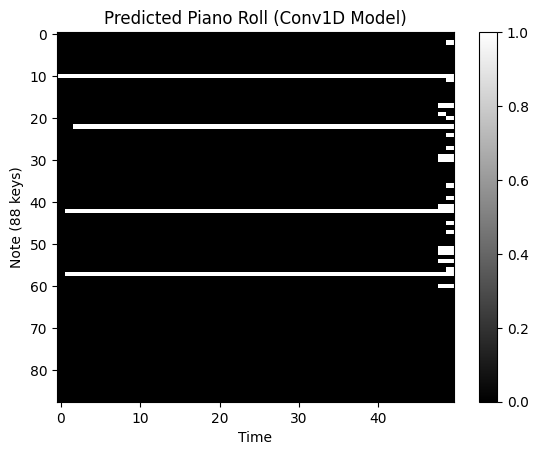

In [ ]:
loss, accuracy = model_cnn1d.evaluate(X_test, Y_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict one test sample
import matplotlib.pyplot as plt

i = 0
pred = model_cnn1d.predict(X_test[i:i+1])[0]
pred_binary = (pred > 0.5).astype(int)

plt.imshow(pred_binary, aspect='auto', cmap='gray')
plt.title("Predicted Piano Roll (Conv1D Model)")
plt.xlabel("Time")
plt.ylabel("Note (88 keys)")
plt.colorbar()
plt.show()


### cnn_model_2 Model accuracy gave the best evaluation performance among above 3 models, which is 64% on test data using 20% of 2018 year datafiles.

#### Try tuning hyperparameters
The above was simpler model which gave moderate accuracy to predict MIDI notes from music.

Now I will try more complex models in 5 combinations with dropouts and learning rate hyperparameters and trying different kernel sizes.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Search Space for Model Variations
experiments = [
    {"filters": (32, 64), "kernel": (3, 3), "dropout": 0.3, "lr": 0.001},
    {"filters": (64, 128), "kernel": (5, 5), "dropout": 0.3, "lr": 0.001},
    {"filters": (64, 128), "kernel": (5, 5), "dropout": 0.4, "lr": 0.0005},
    {"filters": (32, 64, 128), "kernel": (3, 3), "dropout": 0.4, "lr": 0.0005},
    {"filters": (64, 128, 256), "kernel": (5, 5), "dropout": 0.5, "lr": 0.0005},
]

results = []

# Function to Build Model Dynamically
def build_model(filters, kernel_size, dropout, lr):
    model = models.Sequential()
    model.add(layers.Input(shape=(128, 100, 1)))

    for f in filters:
        model.add(layers.Conv2D(f, kernel_size, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(88 * 100, activation='sigmoid'))
    model.add(layers.Reshape((88, 100)))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Run All Experiments
for idx, exp in enumerate(experiments):
    print(f"\n=== Running Experiment {idx + 1} ===")

    model = build_model(exp["filters"], exp["kernel"], exp["dropout"], exp["lr"])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, Y_train,
                        epochs=30,
                        batch_size=8,
                        validation_data=(X_test, Y_test),
                        callbacks=[early_stop],
                        verbose=2)

    loss, acc = model.evaluate(X_test, Y_test, verbose=0)

    results.append({
        "Experiment": idx + 1,
        "Filters": exp["filters"],
        "Kernel Size": exp["kernel"],
        "Dropout": exp["dropout"],
        "Learning Rate": exp["lr"],
        "Test Accuracy": acc,
        "Test Loss": loss
    })

# View All Results
df_results = pd.DataFrame(results)
print(df_results)



=== Running Experiment 1 ===
Epoch 1/30
5/5 - 5s - 996ms/step - accuracy: 0.0080 - loss: 0.7530 - val_accuracy: 0.0102 - val_loss: 0.2614
Epoch 2/30
5/5 - 2s - 398ms/step - accuracy: 0.0082 - loss: 0.2754 - val_accuracy: 0.0023 - val_loss: 0.2545
Epoch 3/30
5/5 - 4s - 821ms/step - accuracy: 0.0068 - loss: 0.0762 - val_accuracy: 0.0011 - val_loss: 0.1714
Epoch 4/30
5/5 - 5s - 1s/step - accuracy: 0.0088 - loss: -1.7731e-01 - val_accuracy: 0.0000e+00 - val_loss: 0.1225
Epoch 5/30
5/5 - 2s - 410ms/step - accuracy: 0.0097 - loss: -3.0766e-01 - val_accuracy: 0.0000e+00 - val_loss: 0.1315
Epoch 6/30
5/5 - 2s - 495ms/step - accuracy: 0.0114 - loss: -6.7458e-01 - val_accuracy: 0.0000e+00 - val_loss: 0.1256
Epoch 7/30
5/5 - 2s - 394ms/step - accuracy: 0.0105 - loss: -9.7672e-01 - val_accuracy: 0.0011 - val_loss: 0.2099
Epoch 8/30
5/5 - 2s - 395ms/step - accuracy: 0.0122 - loss: -1.2037e+00 - val_accuracy: 0.0011 - val_loss: 0.2854
Epoch 9/30
5/5 - 2s - 392ms/step - accuracy: 0.0153 - loss: -1.2

In [ ]:
best_result = df_results.sort_values(by='Test Accuracy', ascending=False).head(1)
print("Best performing experiment:")
print(best_result)


Best performing experiment:
   Experiment        Filters Kernel Size  Dropout  Learning Rate  \
3           4  (32, 64, 128)      (3, 3)      0.4         0.0005   

   Test Accuracy  Test Loss  
3       0.017045    0.09058  


### Best Model is built from the above Hyperparameter Tuning Result
Experiment 3 is chosen.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define the architecture
def build_best_model():
    model_choice = models.Sequential([
        layers.Input(shape=(128, 100, 1)),

        # First Conv block
        layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Second Conv block
        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Flatten + Dense
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),

        # Output: 88 notes × 100 time steps
        layers.Dense(88 * 100, activation='sigmoid'),
        layers.Reshape((88, 100))
    ])

    model_choice.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model_choice

# 2. Build and train the model
model_best = build_best_model()
model_best.summary()

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 3. Train
history_best = model_best.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop],
    verbose=2
)

# 4. Evaluate
loss, accuracy = model_best.evaluate(X_test, Y_test)
print(f"\nTest Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 128, 100, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 64, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 64, 50, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 32, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │      52,429,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8800)                │       4,514,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_10 (Reshape)                 │ (None, 88, 100)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,151,072 (218.01 MB)

 Trainable params: 57,150,688 (218.01 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
5/5 - 9s - 2s/step - accuracy: 0.0082 - loss: 0.8589 - val_accuracy: 0.0068 - val_loss: 0.5078
Epoch 2/30
5/5 - 5s - 1s/step - accuracy: 0.0063 - loss: 0.4386 - val_accuracy: 0.0023 - val_loss: 0.3135
Epoch 3/30
5/5 - 5s - 969ms/step - accuracy: 0.0080 - loss: 0.1824 - val_accuracy: 0.0034 - val_loss: 0.1413
Epoch 4/30
5/5 - 5s - 978ms/step - accuracy: 0.0082 - loss: -7.6409e-02 - val_accuracy: 0.0034 - val_loss: 0.1313
Epoch 5/30
5/5 - 9s - 2s/step - accuracy: 0.0071 - loss: -2.4731e-01 - val_accuracy: 0.0045 - val_loss: 0.1065
Epoch 6/30
5/5 - 5s - 988ms/step - accuracy: 0.0080 - loss: -5.0917e-01 - val_accuracy: 0.0045 - val_loss: 0.0584
Epoch 7/30
5/5 - 5s - 973ms/step - accuracy: 0.0105 - loss: -7.0423e-01 - val_accuracy: 0.0057 - val_loss: 0.0275
Epoch 8/30
5/5 - 5s - 959ms/step - accuracy: 0.0142 - loss: -9.6042e-01 - val_accuracy: 0.0045 - val_loss: 0.0386
Epoch 9/30
5/5 - 5s - 952ms/step - accuracy: 0.0134 - loss: -1.0235e+00 - val_accuracy: 0.0080 - val_loss: 0.046

Loss (especially binary cross-entropy in your case) does take time into account — it is computed over all notes at all time steps.

Accuracy in model.compile(..., metrics=['accuracy']) does not meaningfully capture temporal structure. It is a simple average over individual predictions (note + frame), not sequences.




### Calculate F1 Score

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# 1) Run the model to get predicted probabilities
y_pred_proba = model_best.predict(X_test)
# y_pred_proba shape: (N, 88, 100)

# 2) Binarize predictions at 0.5
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# 3) Make sure your Y_test is binary ints too
#    If Y_test is already 0/1 ints you can omit the thresholding step
y_true_binary = (Y_test > 0.5).astype(int)

# 4) Flatten each sample to a vector
#    New shape: (N, 88*100)
y_pred_flat = y_pred_binary.reshape(y_pred_binary.shape[0], -1)
y_true_flat = y_true_binary.reshape(y_true_binary.shape[0], -1)

# 5) Compute multi-label (frame-level) metrics
f1        = f1_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
recall    = recall_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)

print(f"F1 Score   : {f1:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
F1 Score   : 0.0484
Precision  : 0.0271
Recall     : 0.5466


### Here's how I'd read those numbers:

F1 Score = 0.0484
The F1 is the harmonic-mean of precision and recall. An F1 of ~0.05 is extremely low, indicating that the balance between finding true note-events and avoiding false alarms is poor.

Precision = 0.0271
Of all the “note on” predictions your model made, only about 2.7 % were actually correct. In other words, for every 100 notes it says should be on, about 97 of them are false positives.

Recall = 0.5466
The model is catching about 54.7 % of the real note-on events. So it's sensitive enough to see roughly half of the true notes, but it's doing so at the cost of a huge number of incorrect predictions (hence the very low precision).

In short, while this model is sensitive enough to see many of the true notes, it needs more work to discriminate them from false alarms.

At this stage this is a good starting point.

## What F1 measures

Precision asks: of all the note-time cells I predicted ON, what fraction were actually ON in the ground truth?

Recall asks: of all the note-time cells that truly are ON, what fraction did I predict ON?

F1 is the harmonic mean of those — if I predict a C4 at frame 27 but the ground truth had no C4 at frame 27, that counts against precision; if the truth had a G5 at frame 42 but I missed it, that counts against recall.

### Lets save the model_best to GCS

In [ ]:
model_best.export("/tmp/model_best")  # TensorFlow SavedModel format


Saved artifact at '/tmp/model_best'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 100, 1), dtype=tf.float32, name='keras_tensor_641')
Output Type:
  TensorSpec(shape=(None, 88, 100), dtype=tf.float32, name=None)
Captures:
  140453023479792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023466064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023470288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023471344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023475744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023471168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140452877020400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023474512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140452877379616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023474864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14045

In [ ]:
from google.cloud import storage
import os

def upload_folder_to_gcs(local_folder, bucket_name, gcs_prefix):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    for root, _, files in os.walk(local_folder):
        for file in files:
            local_path = os.path.join(root, file)
            rel_path = os.path.relpath(local_path, local_folder)
            gcs_path = os.path.join(gcs_prefix, rel_path)

            blob = bucket.blob(gcs_path)
            blob.upload_from_filename(local_path)
            print(f"Uploaded: {local_path} → gs://{bucket_name}/{gcs_path}")

# Run the upload
upload_folder_to_gcs("/tmp/model_best", "models_created", "models/model_best")


Uploaded: /tmp/model_best/saved_model.pb → gs://models_created/models/model_best/saved_model.pb
Uploaded: /tmp/model_best/fingerprint.pb → gs://models_created/models/model_best/fingerprint.pb
Uploaded: /tmp/model_best/variables/variables.data-00000-of-00001 → gs://models_created/models/model_best/variables/variables.data-00000-of-00001
Uploaded: /tmp/model_best/variables/variables.index → gs://models_created/models/model_best/variables/variables.index


In [ ]:
from google.cloud import storage

# Save to /tmp
np.save('/tmp/X_train.npy', X_train)
np.save('/tmp/X_test.npy', X_test)
np.save('/tmp/Y_train.npy', Y_train)
np.save('/tmp/Y_test.npy', Y_test)

client = storage.Client()
bucket = client.bucket('processed_audio_for_model_use')
x_train_blob = bucket.blob('2018/X_train.npy')  # Adjust GCS path as needed
x_train_blob.upload_from_filename('/tmp/X_train.npy')

x_train_blob = bucket.blob('2018/X_test.npy')  # Adjust GCS path as needed
x_train_blob.upload_from_filename('/tmp/X_test.npy')

x_train_blob = bucket.blob('2018/Y_train.npy')  # Adjust GCS path as needed
x_train_blob.upload_from_filename('/tmp/Y_train.npy')

x_train_blob = bucket.blob('2018/Y_test.npy')  # Adjust GCS path as needed
x_train_blob.upload_from_filename('/tmp/Y_test.npy')

print("Upload complete.")


Upload complete.


# Deploy the baseline model
Since the above model gave least loss, it will be deployed.

In [ ]:
# Export model
model_best.export('audio2midi_cnn_model')



Saved artifact at 'audio2midi_cnn_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 100, 1), dtype=tf.float32, name='keras_tensor_641')
Output Type:
  TensorSpec(shape=(None, 88, 100), dtype=tf.float32, name=None)
Captures:
  140453023479792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023466064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023470288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023471344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023475744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023471168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140452877020400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023474512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140452877379616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140453023474864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

The model is now ready to be saved in the correct format. Will save it in GCS.

In [ ]:
bucket_name = 'models_created'  # example: 'monobina-saha'
model_path = 'models/audio2midi_cnn_model'

!gsutil -m cp -r audio2midi_cnn_model gs://{bucket_name}/{model_path}


Copying file://audio2midi_cnn_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://audio2midi_cnn_model/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://audio2midi_cnn_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://audio2midi_cnn_model/fingerprint.pb [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksum

#### Upload the Model to Vertex AI Model Registry

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project='monobina-saha', location='us-central1')

model = aiplatform.Model.upload(
    display_name='audio2midi-cnn-model',
    artifact_uri=f'gs://{bucket_name}/{model_path}',
    serving_container_image_uri='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest'
)


INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/353746728936/locations/us-central1/models/1411952150459711488/operations/5222183630637367296
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/353746728936/locations/us-central1/models/1411952150459711488@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/353746728936/locations/us-central1/models/1411952150459711488@1')


## Deployment in Vertex AI endpoint

In [ ]:
endpoint = model.deploy(machine_type='n1-standard-2')


INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/353746728936/locations/us-central1/endpoints/5592895692612829184/operations/5351662119924269056
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/353746728936/locations/us-central1/endpoints/5592895692612829184
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/353746728936/locations/us-central1/endpoints/5592895692612829184')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/353746728936/locations/us-central1/endpoints/5592895692612829184
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/353746728936/locations/us-central1/endpoints/5592895692612829184/operations/8146145688707661824
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/35374672893

# Make a Gen AI Application and call the Model from the App Using Natural Language

### Deploy a cloud function to call vertex endpoint
test-vertex-ai-call - this CF deos that. url: https://test-vertex-ai-call-353746728936.us-central1.run.app


### Deploy a cloud function to connect to GCS files
test-gcs-connect - this CF deos that. url: https://test-gcs-connect-353746728936.us-central1.run.app

### Deploy a CF which can download a song from GCS and can extract features using Librosa
test-librosa-on-gcs-audio - this CF deos that. url: https://test-librosa-on-gcs-audio-353746728936.us-central1.run.app

### Deploy a CF which can download a song from GCS, apply librosa for feature extraction and then predict with Vertex AI model endpoint and I can talk in natural language.
audio2midi-model-call - this CF deos that. url: https://audio2midi-model-call-353746728936.us-central1.run.app

Prompt example:
1. Transcribe my audio file and tell me the most common note
2. What is the most repeated note in this song?
3. Which octaves are used the most?
4. Estimate tempo of this piece.
5. Is this audio mostly high or low pitch?
6. List all distinct notes played.

### Call cloud functions from here and prompt in Natural Language to gemini

#### Example Prompt 1: Transcribe my audio file and tell me the most common note.

In [ ]:
import requests
import json

url = "https://audio2midi-model-call-353746728936.us-central1.run.app"

payload = {
    "prompt": "Transcribe my audio file and tell me the most common note",
    "audio_file": "2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
}

headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, headers=headers, data=json.dumps(payload))

print(response.status_code)
print(response.text)


200
{"response": "Prediction complete! Most common note is 10.", "piano_roll_npy_gcs_path": "gs://predicted_piano_roll/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2_piano_roll.npy", "embedding_npy_gcs_path": "gs://predicted_piano_roll/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2_embedding.npy", "piano_roll_summary": "The piano roll has 88 active notes out of 88 possible keys, over a duration of 100 time steps, with an average note density of 2.88 notes per time step.", "audio_caption": "A dense, cascading tapestry of piano notes, a whirlwind of sound spanning the entire keyboard.  Every key finds its moment.\n", "music_mood": "Energetic\n"}


In [ ]:
import requests
import json

url = "https://audio2midi-model-call-353746728936.us-central1.run.app"

# Point noted: Looks like not supporterd as it answers wrong.
payload = {
    "prompt": "Transcribe my audio file and which octaves are used the most?",
    "audio_file": "2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
}

headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, headers=headers, data=json.dumps(payload))

print(response.status_code)
print(response.text)


200
{"response": "Please provide me with the audio file. I cannot access local files on your computer.  You will need to upload it to a service like Vocaroo,  Google Drive, or Dropbox and then share the link with me.\n\nOnce I have the audio, I will need to use a transcription service (I don't have built-in audio processing capabilities). I will then analyze the transcription to determine the most frequently used octaves.  Note that accurately determining octave usage from a transcription alone is challenging and will be an approximation.  A more accurate analysis would require a spectrogram of the audio.\n"}


#### Example Prompt 5: Is this audio mostly high or low pitch?

In [ ]:
import requests
import json

url = "https://audio2midi-model-call-353746728936.us-central1.run.app"

# Point noted: Looks like not supporterd as it answers wrong.
payload = {
    "prompt": "Transcribe my audio file and Is this audio mostly high or low pitch?",
    "audio_file": "2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
}

headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, headers=headers, data=json.dumps(payload))

print(response.status_code)
print(response.text)

200
{"response": "Prediction complete! Most common note is 10.", "piano_roll_npy_gcs_path": "gs://predicted_piano_roll/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2_piano_roll.npy", "embedding_npy_gcs_path": "gs://predicted_piano_roll/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2_embedding.npy", "piano_roll_summary": "The piano roll has 88 active notes out of 88 possible keys, over a duration of 100 time steps, with an average note density of 2.88 notes per time step.", "audio_caption": "A dense, cascading torrent of piano notes, a whirlwind of 88 keys unleashed.  Every possible note finds its voice in this breathless, 100-step journey.\n", "music_mood": "Energetic\n"}


# APPENDIX
## Future Work
1. Try Transformer Model with music data embeddings
2. Use TRansfer Learning

Given time constraint I plan to continue this work to tune my model further by trying other techniques.  


In [ ]:
import numpy as np

# Example test sample
input_sample = X_test[0:1]  # shape: (1, 128, 100, 1)

prediction = endpoint.predict(instances=input_sample.tolist())
print(prediction)


## Create Embeddings of Music Data
Lets create embedding of music audio and model with the embeddings.

In [ ]:
pip install torch torchaudio transformers librosa


In [ ]:
# restart session after installing torch and transformers in previous step

import torch
from transformers import ClapModel, ClapProcessor

# Load the CLAP model and processor
model = ClapModel.from_pretrained("laion/larger_clap_music")
processor = ClapProcessor.from_pretrained("laion/larger_clap_music")


In [ ]:

import librosa

def extract_clap_embedding(mp3_file_path):
    # Load the audio file
    audio_waveform, sample_rate = librosa.load(mp3_file_path, sr=48000)  # CLAP expects 48kHz sample rate

    # Process the audio to match CLAP's input requirements
    inputs = processor(audios=audio_waveform, sampling_rate=sample_rate, return_tensors="pt")

    # Ensure the model is in evaluation mode
    model.eval()

    # Extract the audio embedding
    with torch.no_grad():
        audio_embedding = model.get_audio_features(**inputs)

    return audio_embedding


In [ ]:
import os
import numpy as np
import librosa
import pretty_midi
import torch
from transformers import ClapProcessor, ClapModel

# Load CLAP model
processor = ClapProcessor.from_pretrained("laion/larger_clap_music")
model = ClapModel.from_pretrained("laion/larger_clap_music")

# Embedding extraction function
def extract_clap_embedding(mp3_path):
    audio, sr = librosa.load(mp3_path, sr=48000)
    inputs = processor(audios=audio, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_audio_features(**inputs)
    return embedding.squeeze()  # shape: (512,)

# Set up paths
data_dir = "sample_data"
X = []
Y = []

max_files = 50
count = 0

for filename in os.listdir(data_dir):
    if filename.endswith(".mp3"):
        base_name = os.path.splitext(filename)[0]
        mp3_path = os.path.join(data_dir, base_name + ".mp3")
        midi_path = os.path.join(data_dir, base_name + ".midi")  # adjust to .mid if needed

        if os.path.exists(midi_path):
            try:
                # 1. Extract CLAP embedding
                embedding = extract_clap_embedding(mp3_path)

                # 2. Process MIDI file to get a simple label (e.g., most frequent note)
                midi = pretty_midi.PrettyMIDI(midi_path)
                notes = [note.pitch for inst in midi.instruments for note in inst.notes]

                if not notes:
                    continue  # skip files with no notes

                label = max(set(notes), key=notes.count)  # most frequent note

                # 3. Append to dataset
                X.append(embedding.numpy())
                Y.append(label)
                count += 1

                if count >= max_files:
                    break

            except Exception as e:
                print(f"Error processing {base_name}: {e}")
                continue

# Convert to NumPy arrays
X = np.array(X)
Y = np.array(Y)

print("X shape:", X.shape)  # should be (50, 512)
print("Y shape:", Y.shape)  # should be (50,)



### Obtained CLAP embeddings
In the above step CLAP embeddings of music are created.

### Use a Dense Neural Network (MLP)
If you’re working with mean pooled embeddings (e.g., np.mean(embeddings, axis=0)), just use:

In [ ]:
#Option 1
from tensorflow.keras import layers, models

# Change the input shape to match the actual shape of the CLAP embeddings (512)
model = models.Sequential([
    layers.Input(shape=(512,)),  # or 1024, depending on embedding
    layers.Dense(256, activation='relu'),
    layers.Dense(88, activation='softmax')  # 88 possible MIDI notes (21 to 108),
])


In [ ]:
from tensorflow.keras.utils import to_categorical

# Map MIDI notes to index 0–87
Y_indexed = np.array([note - 21 for note in Y])  # MIDI notes 21–108

# One-hot encode the labels
Y_onehot = to_categorical(Y_indexed, num_classes=88)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, test_size=0.2, random_state=42)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=20, batch_size=8, validation_data=(X_test, Y_test))


In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.2f}")


### Using CLAP embedding my test accuracy lowered. It might be because CLAP is not trained specifically for piano audio notes.

### Option 2: Use Conv1D if Embeddings Are Temporal
If your CLAP/OpenL3 embedding is shaped like (frames, 512):

You can treat it as a 1D "sequence" input
Use Conv1D instead of Conv2D:

In [ ]:
# TORUN
model = models.Sequential([
    layers.Input(shape=(time_steps, 512)),  # e.g., (96, 512)
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(88 * 100, activation='sigmoid'),
    layers.Reshape((88, 100))
])


In [ ]:
#TORUN
X_reshaped = embedding.reshape(32, 32)  # only if dims fit
X_reshaped = np.expand_dims(X_reshaped, axis=-1)


In [ ]:
from transformers import ClapAudioModel, ClapProcessor

processor = ClapProcessor.from_pretrained("laion/larger_clap_music")
clap_model = ClapAudioModel.from_pretrained("laion/larger_clap_music")

In [ ]:
def extract_clap_embedding_sequence(mp3_path):
    import torch

    # Load audio
    audio, sr = librosa.load(mp3_path, sr=48000)

    # Preprocess for CLAP
    inputs = processor(audios=audio, sampling_rate=sr, return_tensors="pt")

    # Get hidden states
    with torch.no_grad():
        outputs = clap_model(**inputs, output_hidden_states=True)

    # Assume last hidden state shape: (1, tokens=1024, patch_h=8, patch_w=8)
    hs = outputs.hidden_states[-1]  # shape: (1, 1024, 8, 8)

    # Flatten patches: (1024, 8, 8) → (64, 1024)
    hs = hs.squeeze(0)  # (1024, 8, 8)
    hs_flat = hs.reshape(hs.shape[0], -1).T  # shape: (64, 1024)

    return hs_flat  # shape: (time_steps=64, embedding_dim=1024)





In [ ]:
### Step 2: Normalize Length (Pad or Truncate to 96 frames)
test_emb = extract_clap_embedding_sequence("sample_data/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3")
print("Test embedding shape:", test_emb.shape)


In [ ]:
def pad_or_truncate(seq, target_len=96):
    # Make sure the sequence is 2D
    if seq.ndim == 1:
        raise ValueError(f"Expected 2D embedding, but got 1D shape: {seq.shape}")

    if seq.shape[0] >= target_len:
        return seq[:target_len, :]
    else:
        pad_len = target_len - seq.shape[0]
        pad = np.zeros((pad_len, seq.shape[1]))
        return np.vstack((seq, pad))


In [ ]:
test_emb_padded = pad_or_truncate(test_emb, target_len=96)
print(test_emb_padded.shape)  # Expected: (96, 1024)


In [ ]:
X = []
Y = []
count = 0
max_files = 50

for filename in os.listdir(data_dir):
    if filename.endswith(".mp3"):
        base = filename[:-4]
        mp3_path = os.path.join(data_dir, base + ".mp3")
        midi_path = os.path.join(data_dir, base + ".midi")

        if os.path.exists(midi_path):
            try:
                emb = extract_clap_embedding_sequence(mp3_path)
                emb = pad_or_truncate(emb, 96)  # ➕ this step

                midi = pretty_midi.PrettyMIDI(midi_path)
                notes = [n.pitch for inst in midi.instruments for n in inst.notes]

                if notes:
                    label = max(set(notes), key=notes.count)
                    X.append(emb)
                    Y.append(label)
                    count += 1
            except Exception as e:
                print(f"Skipping {base}: {e}")

        if count >= max_files:
            break

X = np.array(X)  # shape: (50, 96, 1024)
Y = np.array([note - 21 for note in Y])  # MIDI note labels 0–87



In [ ]:
X = np.array(X)  # shape: (50, 96, 512)
Y_indexed = np.array([note - 21 for note in Y])  # MIDI note → class index
print("X shape:", X.shape)
print("Y_indexed:",Y_indexed.shape)

In [ ]:
# debugging why X is returning 2D object
print("Example X[0] shape:", X[0].shape)


In [ ]:
from tensorflow.keras.utils import to_categorical

Y_onehot = to_categorical(Y_indexed, num_classes=88)


In [ ]:
#X = np.array(X)  # This should shape to (50, 96, 512)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, test_size=0.2, random_state=42)


In [ ]:
print("X_train shape:", X_train.shape)


In [ ]:
from tensorflow.keras import layers, models

conv1d_model = models.Sequential([
    layers.Input(shape=(96, 1024)),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(88, activation='softmax')  # one for each MIDI note
])


In [ ]:
conv1d_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = conv1d_model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_test, Y_test)
)


In [ ]:
loss, acc = conv1d_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {acc:.2f}")


In [ ]:
from tensorflow.keras import layers, models

lstm_model = models.Sequential([
    layers.Input(shape=(96, 1024)),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(88, activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


In [ ]:
lstm_model.fit(X_train, Y_train, epochs=20, batch_size=8, validation_data=(X_test, Y_test))


In [ ]:
loss, acc = lstm_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {acc:.2f}")


## Prediction Performance Comparison
CLAP embeddings + LSTM or Conv1D giving ~30% accuracy, while raw spectrogram + CNN gave ~54%, definitely raises eyebrows.
### Why Accuracy Is Lower with CLAP Embeddings

1. CLAP Is Not Specifically Trained on Note-Level Labels
CLAP is trained for audio-text alignment, not piano note detection or MIDI note classification. So its embeddings are rich in meaning, but not optimized for low-level pitch detail.

2. Reducing a Complex MIDI Sequence to Just One Note
3. Padding or Truncating can also diorient CLAP frames.

## Audio Data to MIDI Conversion Technique
### Convert mp3 to MIDI
#### Extract Fundamental Frequencies Using Librosa
It is possible to convert mp3 file to MIDI file. We can extract fundamental frequencies and convert them into MIDI notes using librosa library in Python. It is good for single-instrument recordings.

Following code outputs MIDI data in python.

In [ ]:
# Load MP3 file
#train_audio_path = "sample_data/processed_data/MIDI-Unprocessed_unzipped-train.mp3"
y, sr = librosa.load(train_audio_path, sr=22050) # y and sr are the audio data and sampling rate.


# Estimate pitch (frequencies)
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

# Convert to MIDI
midi = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)  # 0 = Acoustic Grand Piano

for t in range(pitches.shape[1]):
    index = np.argmax(magnitudes[:, t])  # Get the most prominent frequency
    pitch = pitches[index, t]
    if pitch > 0:
        note = pretty_midi.Note(
            velocity=100,  # Volume of the note
            pitch=int(librosa.hz_to_midi(pitch)),  # Convert Hz to MIDI note number
            start=t * (1.0 / sr),  # Convert time index to seconds
            end=(t + 1) * (1.0 / sr),
        )
        instrument.notes.append(note)

midi.instruments.append(instrument)

# Save MIDI file
midi.write("sample_data/processed_data/mp3_to_midi.mid")
print("MIDI file saved as mp3_to_midi.mid")

### Piano Roll Generation
Following code outputs Piano Roll.
A piano roll is a visual representation of MIDI data where:

The x-axis represents time.
The y-axis represents MIDI note numbers (pitch).
The intensity of the color or a cell value represents the velocity (loudness) of the note.
fs=100: This is a parameter passed to get_piano_roll. It stands for frames per second and determines the time resolution of the piano roll. In this case, fs=100 means that the piano roll will have 100 time frames per second of audio.

In [ ]:
# Convert to piano roll
piano_roll_generated_midi = midi.get_piano_roll(fs=100)  # fs = frame rate


In [ ]:
# Display piano roll
plt.figure(figsize=(10, 4))
plt.imshow(piano_roll_generated_midi, aspect='auto', cmap='hot', origin='lower')
plt.title('Generated Piano Roll from MP3')
plt.ylabel('MIDI Note')
plt.xlabel('Time')
plt.colorbar()
plt.show()

### Deep Learning based MIDI Conversion

In [ ]:
# to be explored later as magenta may need specific Python version (Python 3.7 - 3.9)
#magenta_convert audio_path magenta_midi_output.mid

### Normalize Data
Normalize Mel Spectogram and piano roll data and plot them.

In [ ]:
# Normalize spectrogram
log_spectrogram = (log_spectrogram - np.mean(log_spectrogram)) / np.std(log_spectrogram)

# Normalize piano roll (binary 0 or 1)
piano_roll = piano_roll > 0

In [ ]:
# Display Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized MIDI Unprocessed Mel Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
# Display piano roll
plt.figure(figsize=(10, 4))
plt.imshow(piano_roll, aspect='auto', cmap='hot', origin='lower')
plt.title('Normalized Piano Roll from MP3')
plt.ylabel('MIDI Note')
plt.xlabel('Time')
plt.colorbar()
plt.show()

## Data Preparation for Model Training
### Generate Input-Output Pairs Using Digitized Audio as Train Set and Piano Roll as Target
### Split data into smaller time windows (e.g., 1-second chunks) for training.


In [ ]:
# Example: Window size and step
window_size = 100  # 100 Timeframes/sec
step_size = 50

# Slice spectrogram and piano roll
X, Y = [], []
for i in range(0, log_spectrogram.shape[1] - window_size, step_size):
    X.append(log_spectrogram[:, i:i+window_size])
    Y.append(piano_roll[:, i:i+window_size])

X = np.array(X)  # Shape: (num_samples, n_mels, window_size)
Y = np.array(Y)  # Shape: (num_samples, n_pitches, window_size)

# checking training data
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Print first sample
print("First X sample:\n", X[0])
print("First Y sample:\n", Y[0])

# print(X.head())
# print(Y.head())

In [ ]:
print(len(X))
print(len(Y))
print(type(X))
print(type(Y))

### Create Dataframe from Numpy Array for KNN Modeling

I have extracted audio features and have them in a NumPy ndarray (audio_features).
I plan to use KNN for modeling.
Given these points, converting my audio_features to a DataFrame would be beneficial. It will make my code more compatible with scikit-learn's KNN implementation and provide a more organized structure for data.

For KNN modeling, using a Pandas DataFrame is generally recommended, especially if you're using scikit-learn for implementation. Here's why:

1. Scikit-learn compatibility: Scikit-learn's KNeighborsClassifier and KNeighborsRegressor are designed to work seamlessly with DataFrames.
2. Feature organization: DataFrames allow you to easily label your features with meaningful column names, which improves code readability and helps in understanding the model's behavior.
3. Data handling: DataFrames provide convenient methods for handling missing values, data cleaning, and other preprocessing steps that might be necessary before applying KNN.
4. Categorical features: If you have any categorical features, DataFrames offer better support for encoding and handling them compared to NumPy arrays.

In [ ]:
# Assuming audio_features has shape (129, 3584)
audio_features_df = pd.DataFrame(audio_features)

# Optionally, add column names
feature_names = [f"feature_{i}" for i in range(3584)]  # Create generic names
audio_features_df.columns = feature_names

print(audio_features_df.head())  # Display the first few rows of the DataFrame



#### Discarding below code now as I have audio features dataframe and Y to be used directly


In [ ]:
# Example dataset (Replace with real data)
# X = []  # Feature vectors (MFCCs)
# Y = []  # Labels (Note names)

# note_files = {
#     "C": "C_note.wav",
#     "D": "D_note.wav",
#     "E": "E_note.wav"
# }

# for note, file in note_files.items():
#     y, sr = librosa.load(audio_path, sr=22050)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#     mfcc_mean = np.mean(mfcc, axis=1)  # Take mean across time
#     X.append(mfcc_mean)
#     Y.append(note)

# X = np.array(X)
# Y = np.array(Y)

## Split Train Test Dataset

In [ ]:
# Split into training/testing
X_train, X_test, Y_train, Y_test = train_test_split(audio_features_df, Y, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

### Understanding the Shapes:

X_train and X_test: These have shapes (103, 3584) and (26, 3584) respectively, which is expected. They represent audio features, with 103 and 26 samples in the training and testing sets, and each sample having 3584 features.

Y_train and Y_test: These have shapes (103, 128, 100) and (26, 128, 100). This indicates that target variable (piano roll data) has three dimensions:
103/26: Number of samples in training/testing sets.
128: Number of MIDI notes (or pitch values) represented in the piano roll.
100: Number of time frames in each window of the piano roll.

### Multi-label or Multi-output:
The shape of Y suggests that I am dealing with a multi-label or multi-output prediction problem. This means that for each audio segment (X), I want to predict a sequence of values representing the piano roll over time. In other words, I am predicting multiple target values simultaneously.

## KNN Model Training
We can train a simple classifier to output MIDI from mp3 audio data.

Since the original target Y has 3 dimensions and KNN cannot handle more than 2 dimensions we need to reshape data.





In [ ]:
# This line gets the dimensions of the original 3D piano roll data.
nsamples_train, nx_train, ny_train = Y_train.shape

# This line reshapes the data into a 2D format. It combines the pitch and time dimensions (nx, ny) into a single feature dimension, resulting in a shape of (num_samples, num_features).
Y_train_2d = Y_train.reshape((nsamples_train, nx_train * ny_train))

# Similar steps are performed for Y_test.
nsamples_test, nx_test, ny_test = Y_test.shape
Y_test_2d = Y_test.reshape((nsamples_test, nx_test * ny_test))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train_2d)  # Use reshaped Y_train

# # Test the model
# accuracy = knn.score(X_test, Y_test_2d)  # Use reshaped Y_test
# print(f"Model Accuracy: {accuracy:.2f}")

### MUST TODO: Hyperparameter Tuning
Hyperparameter Tuning:
n_neighbors: Experiment with different values for the number of neighbors. Start with a range like 3, 5, 7, ..., and observe the effect on the Jaccard score. You might find that a lower or higher number of neighbors leads to better performance.
weights: Try both 'uniform' and 'distance' weighting. 'uniform' gives equal weight to all neighbors, while 'distance' weights closer neighbors more heavily. Depending on the data, one might be more effective.
metric: Explore different distance metrics like 'euclidean', 'manhattan', or others relevant to your data. The choice of distance metric can significantly impact KNN performance.

In [ ]:
# TODO
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='jaccard_samples')  # Use 'jaccard_samples' for multi-label
grid_search.fit(X_train, Y_train)

print("Best parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

## Model Evaluation
Use X_test => 20% of training dataset

In [ ]:

predicted_labels = knn.predict(X_test)



In [ ]:
print(predicted_labels.shape)
print(Y_test_2d.shape)
print(f"Predicted Labels: {predicted_note[0]}")
# print(type(predicted_note))
# print(predicted_note)

## Model Perforamance Measurement

### F1-Score:
The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of accuracy, especially when dealing with imbalanced datasets.

In [ ]:

f1_score_value = f1_score(Y_test_2d, predicted_labels, average='samples')  # 'samples' for multi-label
print(f"F1-Score: {f1_score_value:.2f}")

### Jaccard Score (or Jaccard Similarity)
This metric measures the similarity between the predicted and true sets of labels for each sample. It ranges from 0 to 1, with higher values indicating better performance.

In [ ]:

jaccard_score_value = jaccard_score(Y_test_2d, predicted_labels, average='samples')  # 'samples' for multi-label
print(f"Jaccard Score: {jaccard_score_value:.2f}")

#### Since Jaccard Score values closer to 1 is better, this value indicates it is not a good prediction.


In [ ]:
# will take a look at it later as the ouput report is big
from sklearn.metrics import classification_report

#report = classification_report(Y_test_2d, predicted_labels, zero_division=1)  # Handle zero division



## Normalize Data for Better Performance

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize audio_features_df (StandardScaler for features with Gaussian distribution)
scaler = StandardScaler()
audio_features_df = pd.DataFrame(scaler.fit_transform(audio_features_df), columns=audio_features_df.columns)

# Normalize piano roll (MinMaxScaler for binary data)
# Y is already binary (True/False), but converting to 0/1 is recommended
Y = Y.astype(int)  # Convert True/False to 1/0
# Reshape Y to 2D for scaling
nsamples, nx, ny = Y.shape
Y_2d = Y.reshape((nsamples, nx * ny))
scaler_y = MinMaxScaler()
Y_2d = scaler_y.fit_transform(Y_2d)
# Reshape Y back to 3D
#Y = Y_2d.reshape((nsamples, nx, ny))

# Now you can proceed with train_test_split:
X_train, X_test, Y_train, Y_test = train_test_split(audio_features_df, Y_2d, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

In [ ]:
knn_for_norm = KNeighborsClassifier(n_neighbors=3)
knn_for_norm.fit(X_train, Y_train)


In [ ]:
predicted_labels_for_norm = knn_for_norm.predict(X_test)

In [ ]:
print(predicted_labels_for_norm.shape)
print(Y_test.shape)

In [ ]:
jaccard_score_value_for_norm = jaccard_score(Y_test, predicted_labels_for_norm, average='samples')  # 'samples' for multi-label
print(f"Jaccard Score: {jaccard_score_value_for_norm:.2f}")

#### Model Performance slightly increased after normalization.

## Neural Net for Modeling

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disables GPU usage
# Network Architecture:
model = models.Sequential([
    layers.Input(shape=(3584,)),  # Add channel dimension
    layers.Reshape((1, 1, 3584)), # The input shape here may be too narrow.
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Since the input has dimensions 1x1, using 'same' padding will prevent the output size from decreasing.
    layers.MaxPooling2D((2, 2), padding='same'), # Change padding to 'same' for MaxPooling2D
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'), # Change padding to 'same' for MaxPooling2D
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(128 * 100, activation='sigmoid'),  # Output piano roll
    # The output is flattened here to match the shape of Y_train
    layers.Reshape((12800,))
])

# Remove the extra Reshape layer from the original code
# model.add(layers.Reshape((128, 100)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(X_train.shape)
print(Y_train.shape)

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_split=0.2)

In [ ]:
predicted_labels_for_cnn = model.predict(X_test)

In [ ]:
print(predicted_labels_for_cnn.shape)
print(Y_test.shape)

In [ ]:
# Threshold predictions to get binary values
predicted_labels_for_cnn = (predicted_labels_for_cnn > 0.5).astype(int)  # Convert to 0/1

# Now calculate the Jaccard score
jaccard_score_value_for_cnn = jaccard_score(Y_test, predicted_labels_for_cnn, average='samples')  # 'samples' for multi-label
print(f"Jaccard Score: {jaccard_score_value_for_cnn:.2f}")


## TODO
### LSTM
LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) designed to handle sequential data and capture long-term dependencies more effectively than traditional RNNs.
Since there is time component in my dataset, it may perform better than CNN.

#### Why Use LSTM?
Captures temporal dependencies - LSTMs remember past information, useful for sequential data like music.
Processes sequences of notes - Unlike CNNs, which analyze patterns spatially, LSTMs track note progression over time.
Ideal for MIDI conversion - MIDI notes are structured as time-based sequences, making LSTM a good fit.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define LSTM Model
model = models.Sequential([
    layers.Input(shape=(100, 128)),  # (time_steps, features)
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(88, activation='sigmoid'))  # Predict notes per time step
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


#### Train Model

In [ ]:
# Train LSTM model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)


#### Predict MIDI Piano Roll

In [ ]:
# Predict on new spectrogram data
predicted_piano_roll = model.predict(X_test)

# Convert predictions to binary (note on/off)
predicted_piano_roll = (predicted_piano_roll > 0.5).astype(int)


## TODO Transformer Model
Using a Transformer model for MIDI note prediction from spectrogram data can significantly improve capturing long-term dependencies in the sequence compared to LSTMs. Below is a Transformer-based model for predicting MIDI notes from audio features.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# Input Shape (time_steps, features)
input_layer = layers.Input(shape=(100, 128))  # (time_frames, features)

# Stack Transformer Blocks
x = transformer_block(input_layer, head_size=64, num_heads=4, ff_dim=256)
x = transformer_block(x, head_size=64, num_heads=4, ff_dim=256)

# Final Dense Layer to predict notes
x = layers.Dense(88, activation="sigmoid")(x)  # 88 MIDI notes

# Define Model
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print Model Summary
model.summary()


### Training the Model

In [ ]:
# Train Transformer model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)


### Predict MIDI Notes

In [ ]:
# Predict on new spectrogram data
predicted_piano_roll = model.predict(X_test)

# Convert predictions to binary (note on/off)
predicted_piano_roll = (predicted_piano_roll > 0.5).astype(int)


## TODO: Testing New Audio Files with KNN

In [ ]:
# Predict a note from a new audio file
test_audio_path = "sample_data/processed_data/MIDI-Unprocessed_unzipped-test.mp3"
test_audio, _ = librosa.load(test_audio_path, sr=22050)
test_mfcc = librosa.feature.mfcc(y=test_audio, sr=sr, n_mfcc=13)
test_mfcc_mean = np.mean(test_mfcc, axis=1).reshape(1, -1)

predicted_note = knn.predict(test_mfcc_mean)
print(f"Predicted Note: {predicted_note[0]}")
print(type(predicted_note))
print(predicted_note)